In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

from kneed import KneeLocator
from sklearn.cluster import KMeans, Birch
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

In [3]:
data = pd.read_csv('CensusCanada2016Training.csv')

In [4]:
data

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter
0,4051,1441,68242.12,1441,323,199,53,182,526,911,525,5,1343,919,424
1,2329,1026,88172.37,1026,927,70,15,3,0,792,230,4,991,778,213
2,5276,2071,103853.38,2071,3,607,567,651,106,1418,652,1,1903,1522,381
3,5967,2203,82796.63,2203,133,1695,248,79,0,1397,806,0,2079,1272,807
4,4236,1419,91648.22,1419,0,7,127,938,143,914,505,0,1348,1186,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2588,953,108823.38,953,0,3,31,501,276,926,27,0,875,847,28
4996,9036,3859,68735.64,3859,678,986,386,359,448,2388,1436,35,3649,2602,1047
4997,4689,1895,71370.58,1895,164,485,511,523,29,677,1038,180,1764,1219,545
4998,3673,1038,58258.26,1038,544,185,40,95,13,796,242,0,893,546,347


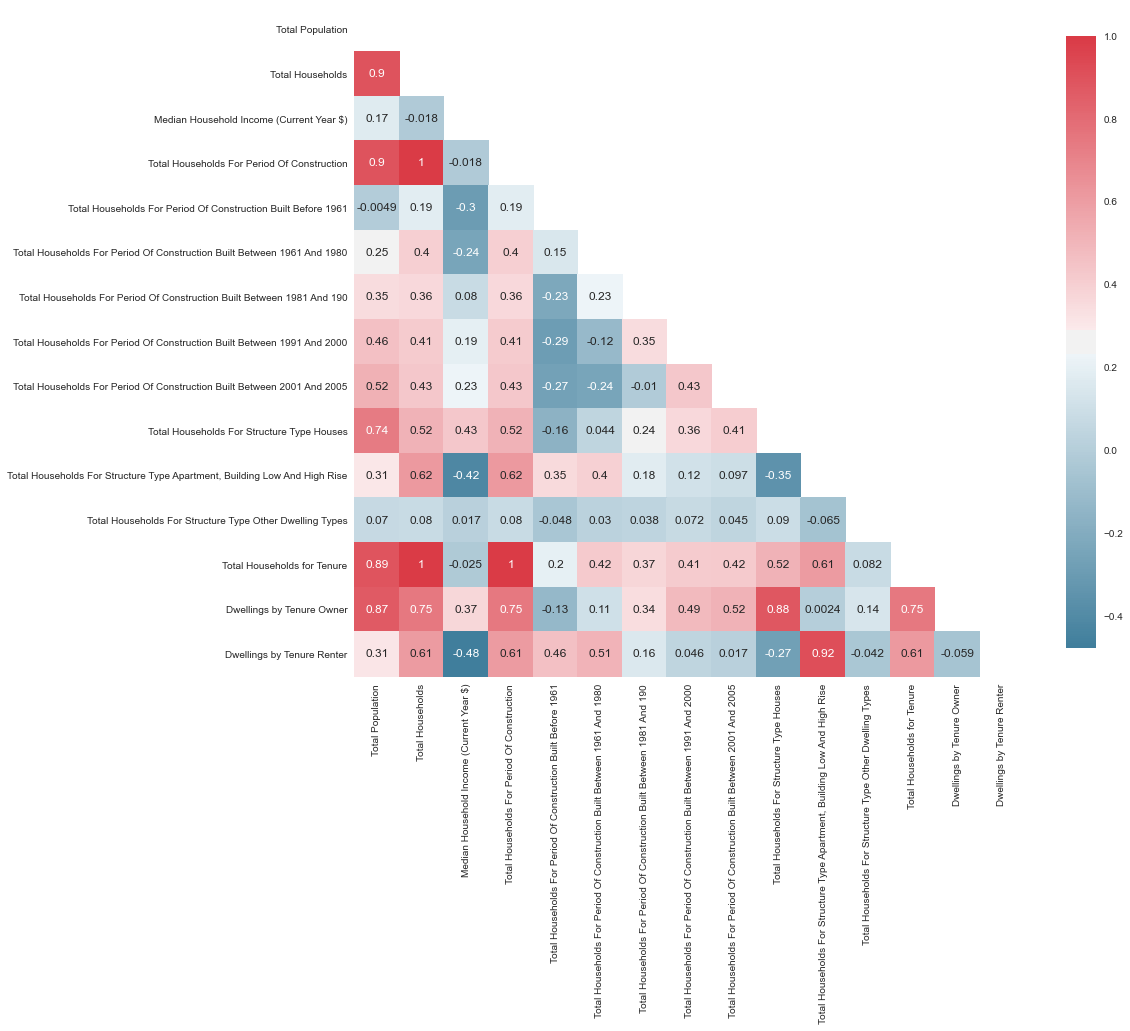

In [5]:
# Correlation matrix
corr = data.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr, 
            mask=np.triu(np.ones_like(corr, dtype=bool)), 
            cmap=sns.diverging_palette(230, 10, as_cmap=True),
            square=True,
            cbar_kws={"shrink": 0.75},
            annot=True,
            annot_kws={'size':12})

In [4]:
data.columns

Index(['Total Population', 'Total Households',
       'Median Household Income (Current Year $)',
       'Total Households For Period Of Construction',
       'Total Households For Period Of Construction Built Before 1961',
       'Total Households For Period Of Construction Built Between 1961 And 1980',
       'Total Households For Period Of Construction Built Between 1981 And 190',
       'Total Households For Period Of Construction Built Between 1991 And 2000',
       'Total Households For Period Of Construction Built Between 2001 And 2005',
       'Total Households For Structure Type Houses',
       'Total Households For Structure Type Apartment, Building Low And High Rise',
       'Total Households For Structure Type Other Dwelling Types',
       'Total Households for Tenure', 'Dwellings by Tenure Owner',
       'Dwellings by Tenure Renter'],
      dtype='object')

# EDA

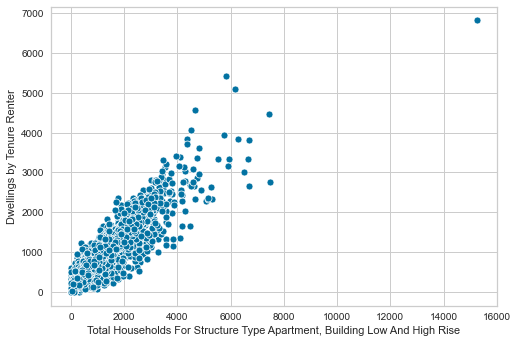

In [5]:
sns.scatterplot(data=data, 
                x="Total Households For Structure Type Apartment, Building Low And High Rise", 
                y="Dwellings by Tenure Renter")

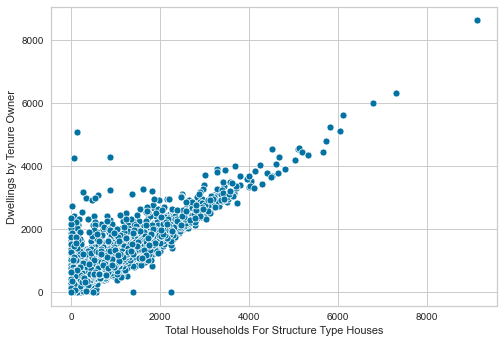

In [6]:
sns.scatterplot(data=data, x="Total Households For Structure Type Houses", y="Dwellings by Tenure Owner")

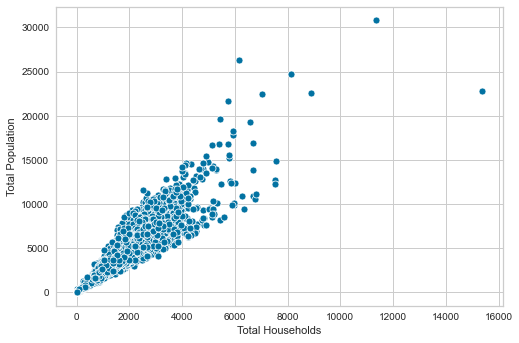

In [7]:
sns.scatterplot(data=data, x="Total Households", y="Total Population")

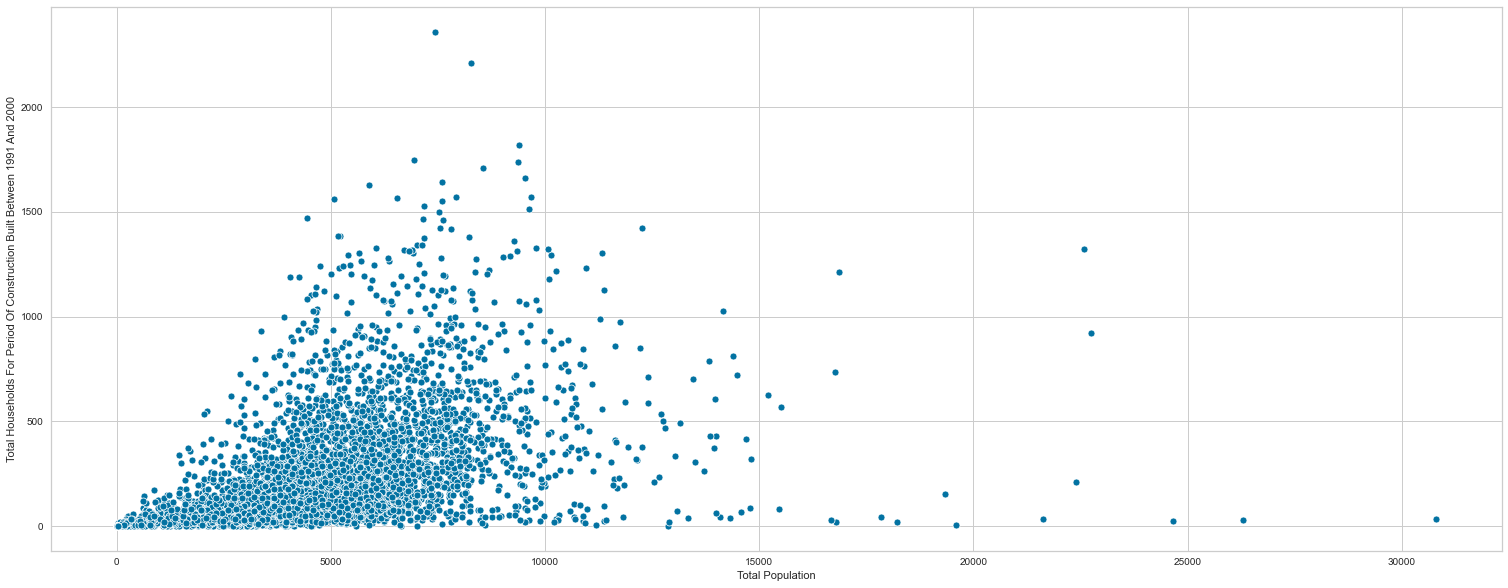

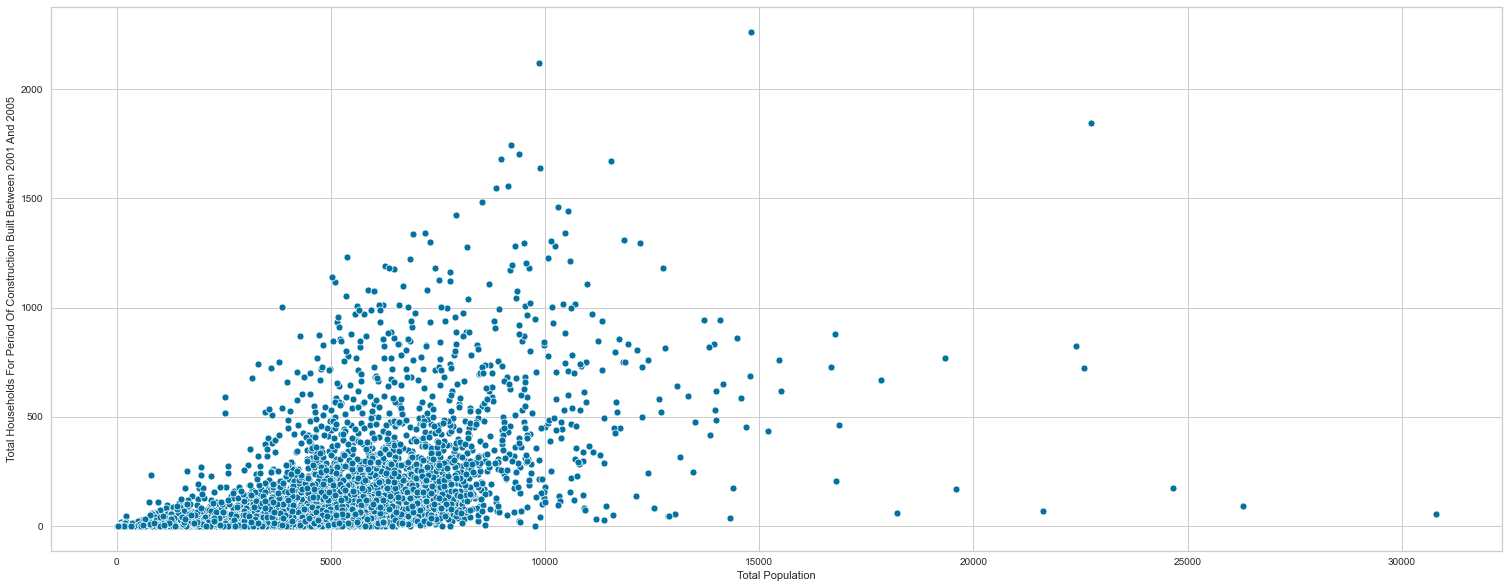

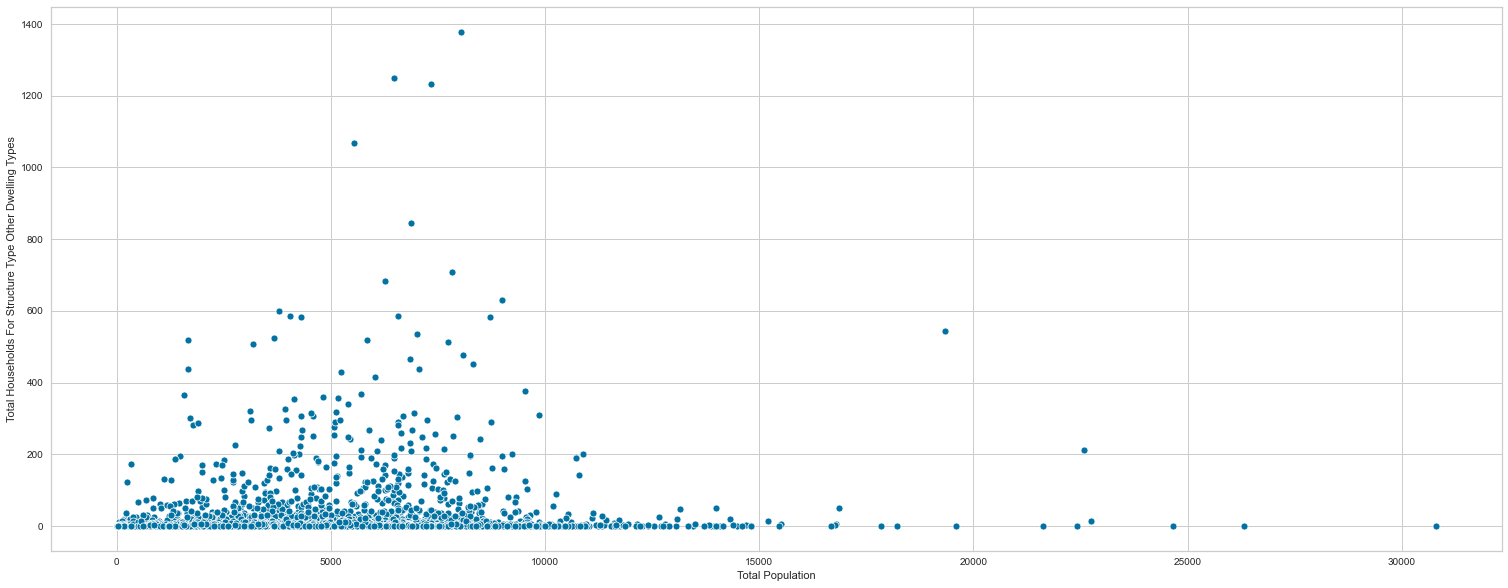

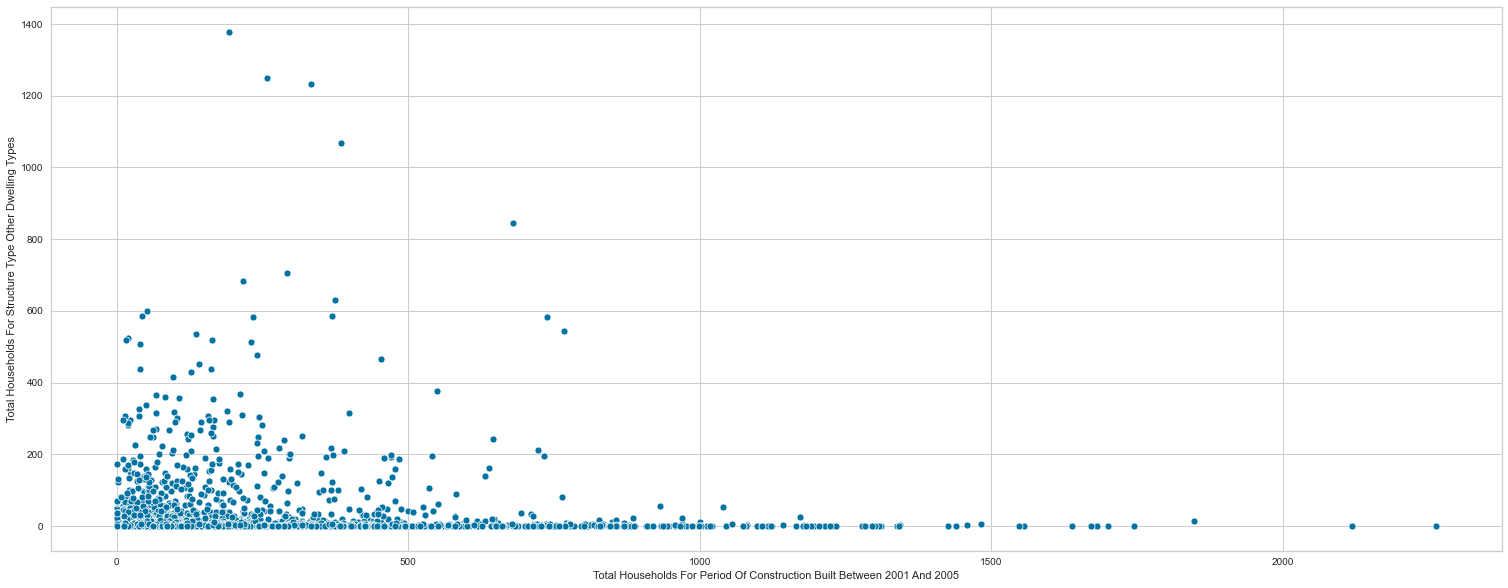

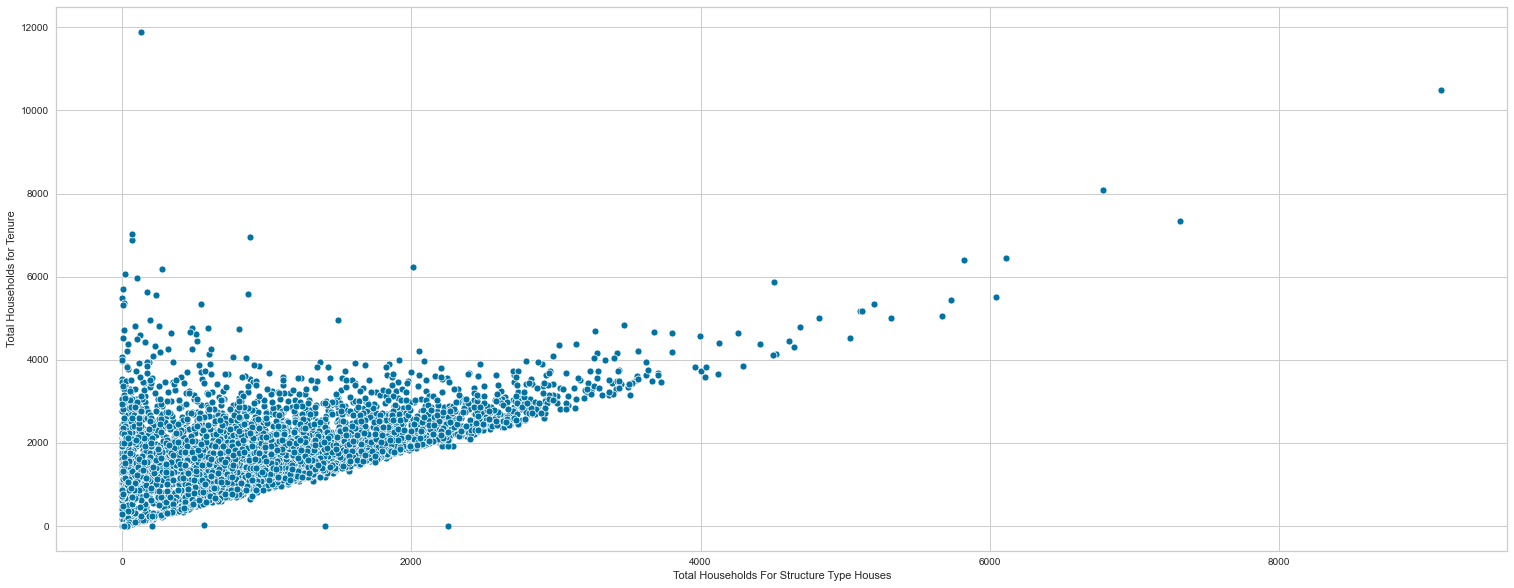

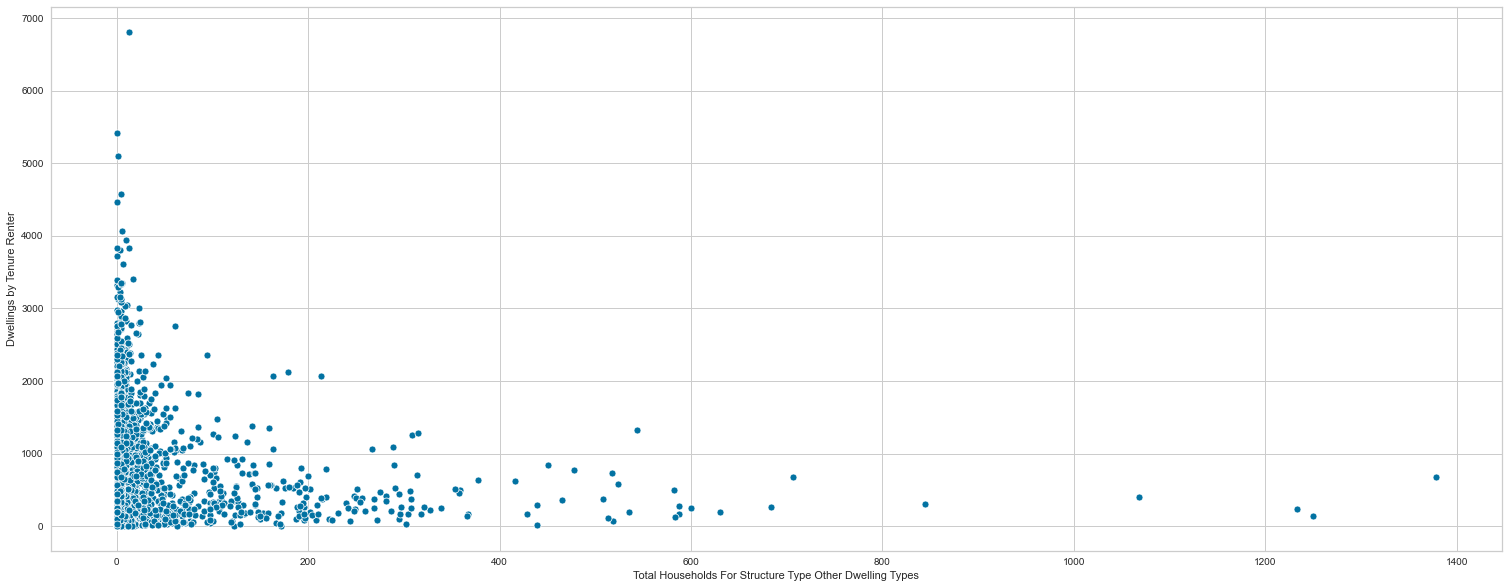

In [8]:
# visualizing highly correlated variables based on the correlation matrix
plt.figure(figsize=(26, 10))
sns.scatterplot(x = data.columns[0], data = data, y = data.columns[7])

plt.figure(figsize=(26, 10))
sns.scatterplot(x = data.columns[0], data = data, y = data.columns[8])

plt.figure(figsize=(26, 10))
sns.scatterplot(x = data.columns[0], data = data, y = data.columns[11])

plt.figure(figsize=(26, 10))
sns.scatterplot(x = data.columns[8], data = data, y = data.columns[11])

plt.figure(figsize=(26, 10))
sns.scatterplot(x = data.columns[9], data = data, y = data.columns[12])

plt.figure(figsize=(26, 10))
sns.scatterplot(x = data.columns[11], data = data, y = data.columns[14])

(0.0, 6000.0)

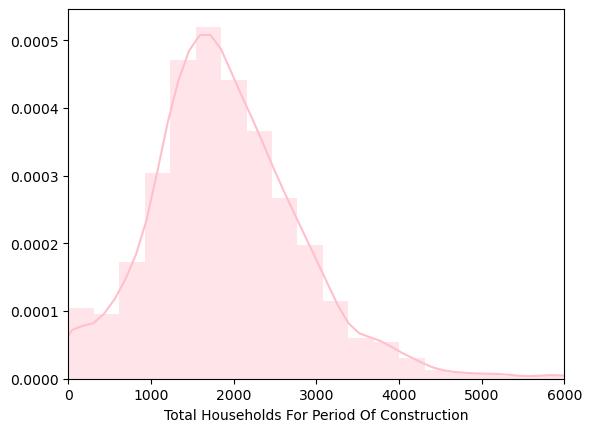

In [9]:
plt.style.use("default")
sns.distplot(data['Total Households For Period Of Construction'], color="pink")
plt.xlim(0,6000)

## Data Pre-processing

In [10]:
# drop equal value columns
df = data.drop(columns=['Total Households For Period Of Construction'])

# remove 20 rows with 0 income
df = df[df['Median Household Income (Current Year $)'] > 0]
df = df.reset_index(drop=True)

# rename columns
df.columns = ['population', 'households', 'income', 
             'hh_before_1961','hh_1961_1980','hh_1981_1990','hh_1991_2000','hh_2001_2005',
             'hh_type_house', 'hh_type_app', 'hh_type_other', 
             'hh_tenure', 'hh_tenure_owner', 'hh_tenure_renter']

# derive additional columns
df['hh_tenure_other'] = df['hh_tenure'] - df['hh_tenure_owner'] - df['hh_tenure_renter']
df['hh_after_2005'] = df['households'] - df['hh_before_1961'] - df['hh_1961_1980'] \
                      - df['hh_1981_1990'] - df['hh_1991_2000'] - df['hh_2001_2005']
df["persons_per_hh"] = df['population']/df['households']

# drop columns
df = df.drop(columns=['population'])
df = df.drop(columns=['hh_tenure'])
df = df.drop(columns=['households'])

In [11]:
df

,income,hh_before_1961,hh_1961_1980,hh_1981_1990,hh_1991_2000,hh_2001_2005,hh_type_house,hh_type_app,hh_type_other,hh_tenure_owner,hh_tenure_renter,hh_tenure_other,hh_after_2005,persons_per_hh
0,68242.12,323,199,53,182,526,911,525,5,919,424,0,158,2.811242
1,88172.37,927,70,15,3,0,792,230,4,778,213,0,11,2.269981
2,103853.38,3,607,567,651,106,1418,652,1,1522,381,0,137,2.547562
3,82796.63,133,1695,248,79,0,1397,806,0,1272,807,0,48,2.708579
4,91648.22,0,7,127,938,143,914,505,0,1186,162,0,204,2.985201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4975,108823.38,0,3,31,501,276,926,27,0,847,28,0,142,2.715635
4976,68735.64,678,986,386,359,448,2388,1436,35,2602,1047,0,1002,2.341539
4977,71370.58,164,485,511,523,29,677,1038,180,1219,545,0,183,2.474406
4978,58258.26,544,185,40,95,13,796,242,0,546,347,0,161,3.538536


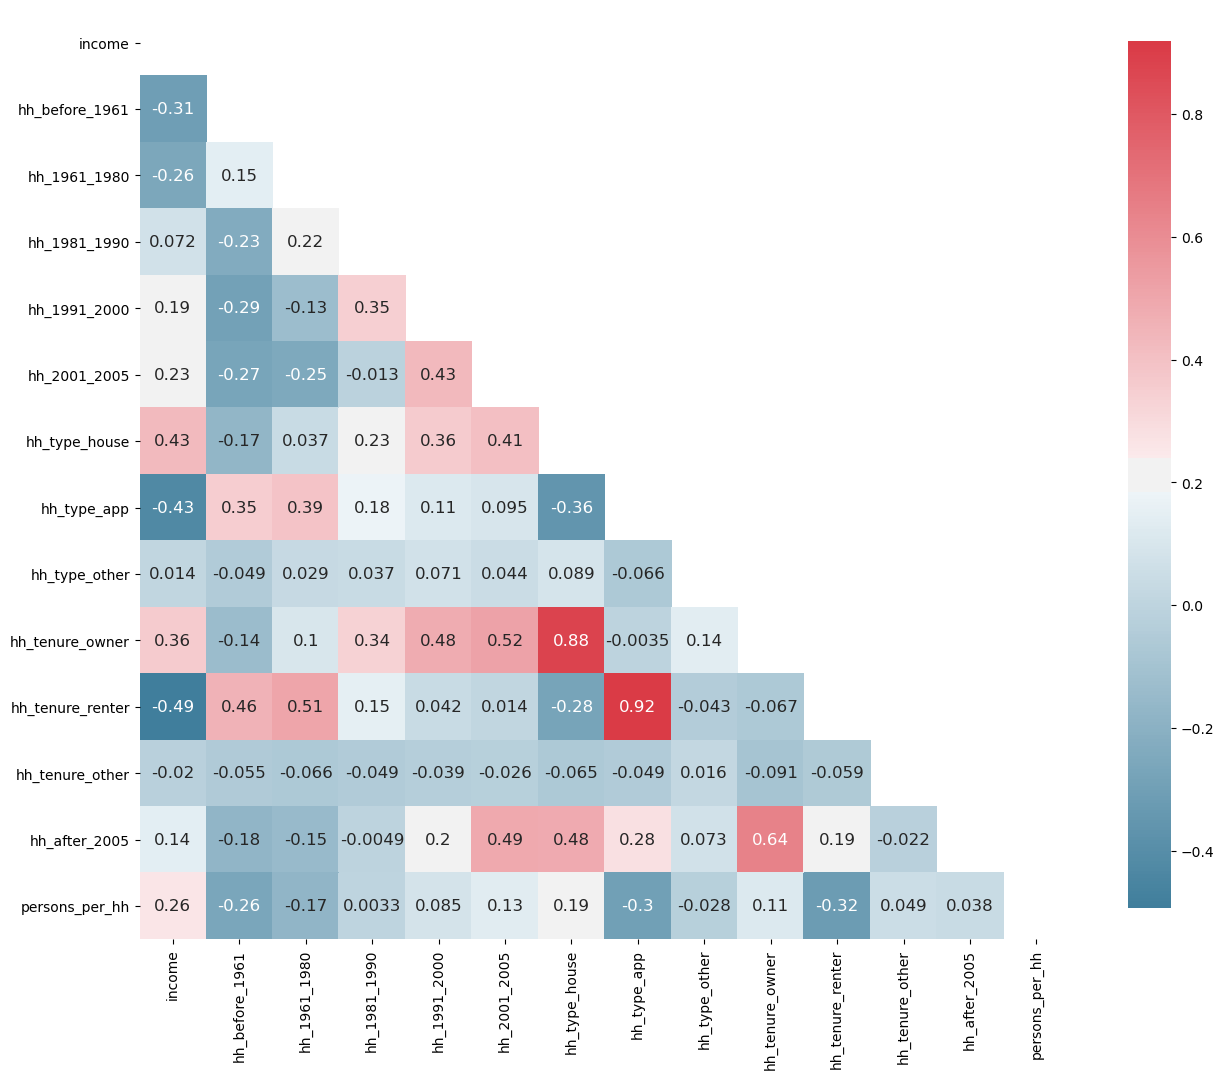

In [12]:
# Correlation matrix
corr = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr, 
            mask=np.triu(np.ones_like(corr, dtype=bool)), 
            cmap=sns.diverging_palette(230, 10, as_cmap=True),
            square=True,
            cbar_kws={"shrink": 0.75},
            annot=True,
            annot_kws={'size':12})

In [13]:
# drop hightly correlated columns
df = df.drop(columns=['hh_tenure_owner'])
df = df.drop(columns=['hh_tenure_renter'])
df = df.drop(columns=['hh_tenure_other'])

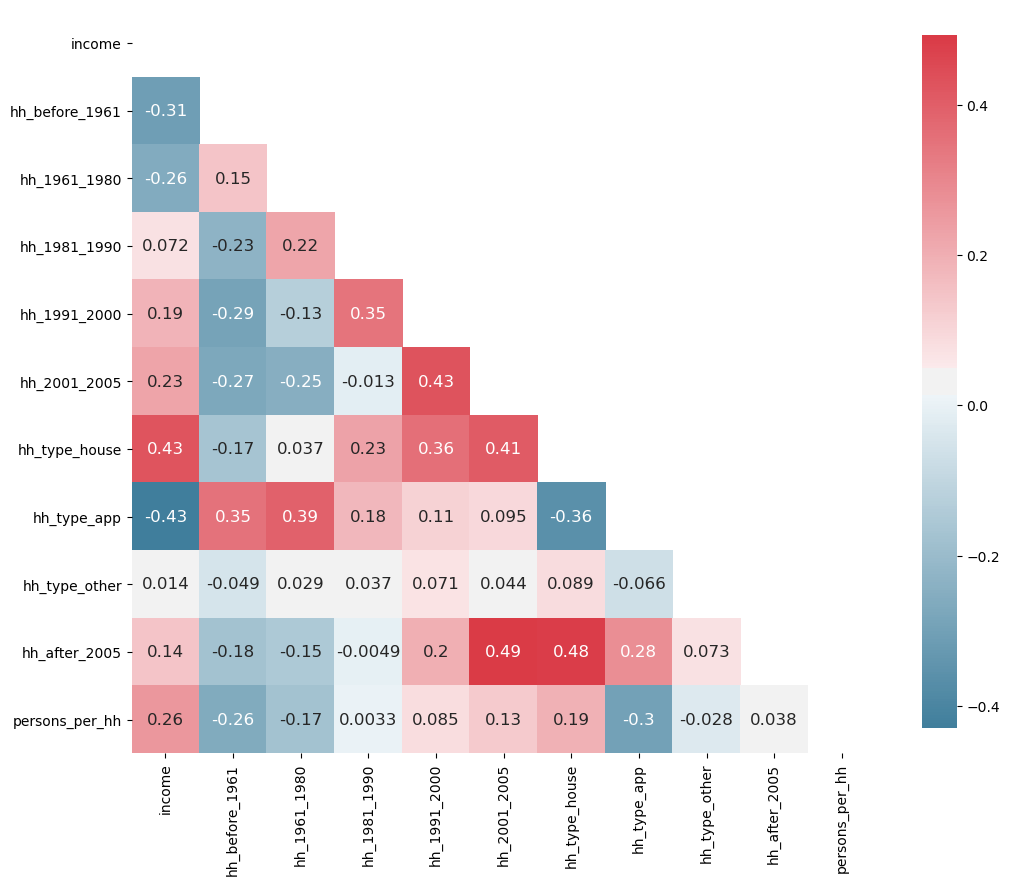

In [14]:
# Correlation matrix
corr = df.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corr, 
            mask=np.triu(np.ones_like(corr, dtype=bool)), 
            cmap=sns.diverging_palette(230, 10, as_cmap=True),
            square=True,
            cbar_kws={"shrink": 0.75},
            annot=True,
            annot_kws={'size':12})

# k-Means Clustering

In [15]:
# scale variables
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

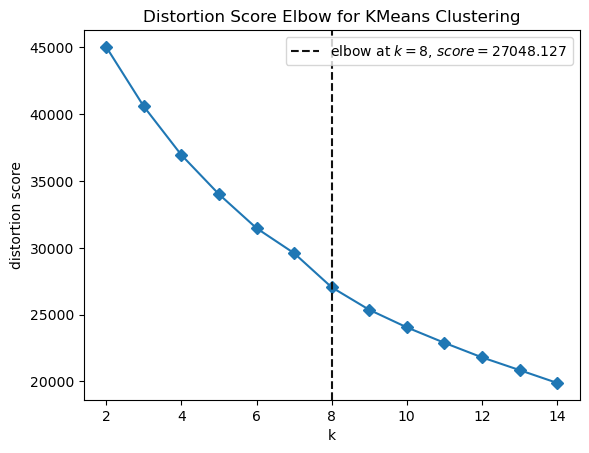

In [16]:
# choose a suitable k  - instantiate the clustering model and visualizer
model = KMeans(random_state=123)
visualizer = KElbowVisualizer(model, k=(2,15), timings=False)
visualizer.fit(scaled_df) 
visualizer.show()

In [17]:
# choose a suitable k - elbow method
kmeans_kwargs = {
    "random_state": 1111,
}

sse = []
for k in range(1, 15):
    model = KMeans(n_clusters = k, **kmeans_kwargs)
    model.fit(scaled_df)
    sse.append(model.inertia_)

Text(0, 0.5, 'SSE')

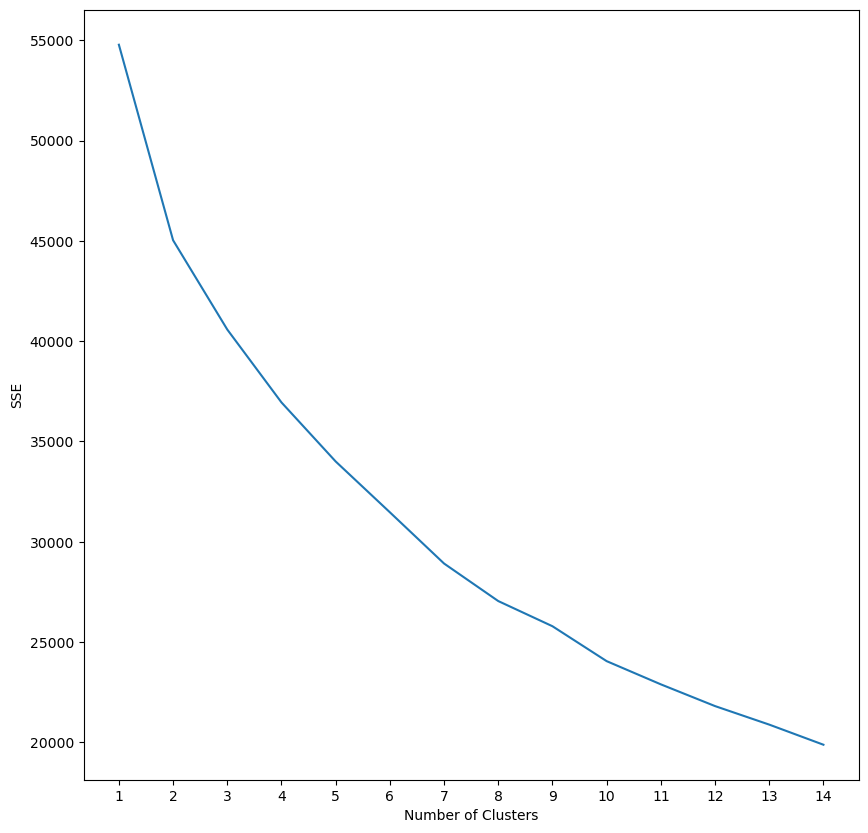

In [19]:
plt.figure(figsize = (10,10))
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

In [20]:
kl = KneeLocator(range(1, 15), sse, curve = "convex", direction = "decreasing")
kl.elbow

5

In [21]:
# choose a suitable k - silhouette coefficient
silhouette_coefficients = []

for k in range(2, 15):
    model = KMeans(n_clusters = k, **kmeans_kwargs)
    model.fit(scaled_df) 
    score = silhouette_score(scaled_df, model.labels_)
    silhouette_coefficients.append(score)

Text(0, 0.5, 'Silhouette Coefficient')

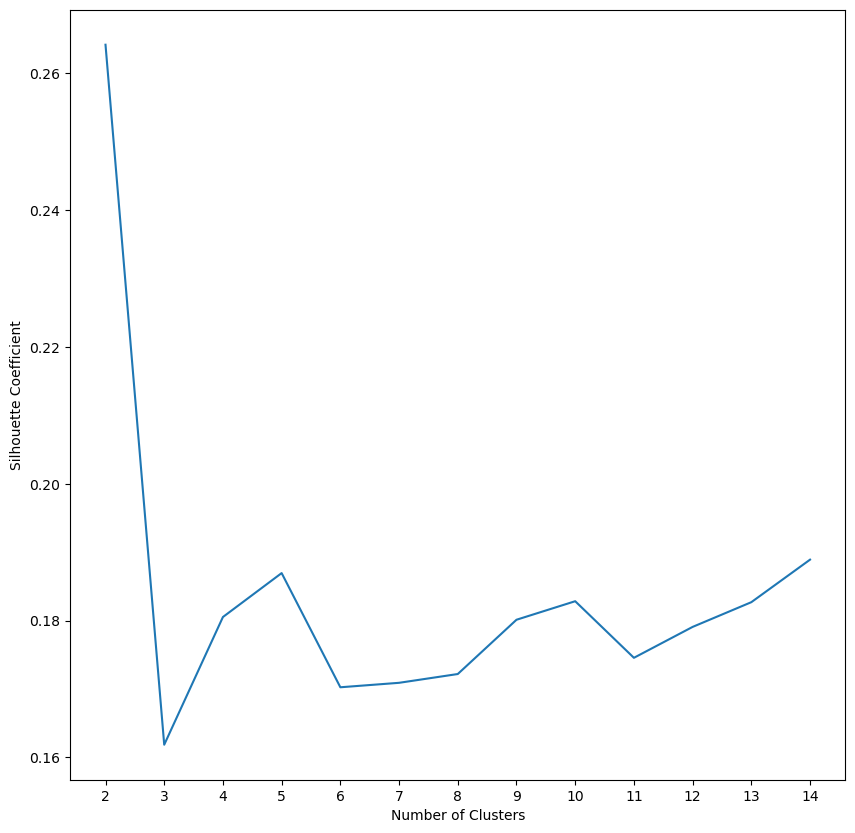

In [22]:
plt.figure(figsize = (10,10))
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")

In [23]:
# final model
model = KMeans(n_clusters = 5, **kmeans_kwargs)
model.fit(scaled_df)

KMeans(n_clusters=5, random_state=1111)

In [24]:
labeled_data = data[data['Median Household Income (Current Year $)'] > 0]
labeled_data = labeled_data.reset_index(drop=True)

In [25]:
# add labels back to original data
labels = pd.DataFrame(model.labels_)
df['labels'] = labels
labeled_data['labels'] = labels
labeled_data

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter,labels
0,4051,1441,68242.12,1441,323,199,53,182,526,911,525,5,1343,919,424,0
1,2329,1026,88172.37,1026,927,70,15,3,0,792,230,4,991,778,213,0
2,5276,2071,103853.38,2071,3,607,567,651,106,1418,652,1,1903,1522,381,3
3,5967,2203,82796.63,2203,133,1695,248,79,0,1397,806,0,2079,1272,807,1
4,4236,1419,91648.22,1419,0,7,127,938,143,914,505,0,1348,1186,162,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4975,2588,953,108823.38,953,0,3,31,501,276,926,27,0,875,847,28,3
4976,9036,3859,68735.64,3859,678,986,386,359,448,2388,1436,35,3649,2602,1047,1
4977,4689,1895,71370.58,1895,164,485,511,523,29,677,1038,180,1764,1219,545,3
4978,3673,1038,58258.26,1038,544,185,40,95,13,796,242,0,893,546,347,0


In [26]:
labeled_data.groupby('labels').mean()

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter
labels,,,,,,,,,,,,,,,
0,3180.061137,1317.436019,69222.866512,1317.436019,524.484360,436.758768,106.481043,80.595735,37.010427,769.559716,539.192417,8.683886,1246.748341,768.863981,476.614218
1,5833.310231,2729.161716,51427.130495,2729.161716,624.809681,1057.130913,349.074807,249.870187,104.680968,672.861386,2048.246425,8.053905,2564.998900,1042.464246,1522.532453
2,5860.950000,2318.412500,82865.744000,2318.412500,173.762500,667.862500,359.250000,364.237500,188.650000,1596.800000,316.612500,405.000000,2187.300000,1797.412500,388.812500
3,5551.864250,1991.425018,98657.546034,1991.425018,151.530206,550.063255,472.690121,390.146411,139.840085,1606.181237,373.743426,11.500355,1876.053305,1532.696517,343.239517
4,8526.987342,2934.335443,101175.993523,2934.335443,65.052743,142.042194,140.533755,452.272152,649.544304,2217.122363,707.181435,10.031646,2696.118143,2195.900844,500.206751


In [27]:
labeled_data['labels'].value_counts()

0    2110
3    1407
1     909
4     474
2      80
Name: labels, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1200x800 with 0 Axes>

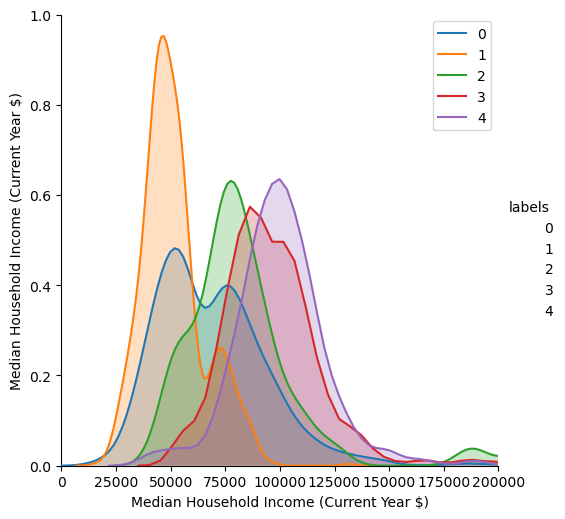

In [28]:
plt.figure(figsize=(12,8))
sns.pairplot(labeled_data[["Median Household Income (Current Year $)", "labels"]], hue="labels", size=5)
plt.xlim(0,200000)
plt.legend()

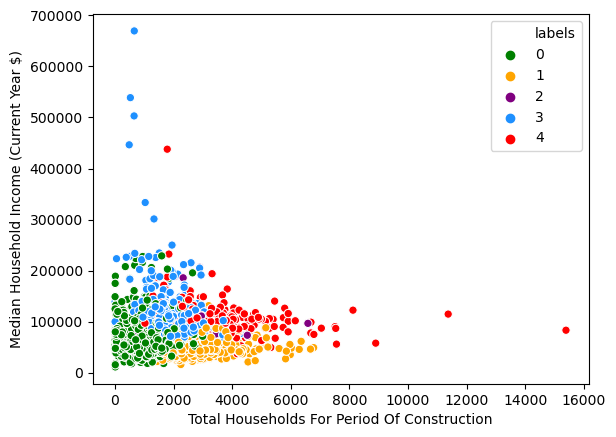

In [68]:
sns.scatterplot(x=labeled_data["Total Households For Period Of Construction"], 
                y=labeled_data["Median Household Income (Current Year $)"],
                hue=labeled_data["labels"],
                palette=['green','orange','purple','dodgerblue','red'])

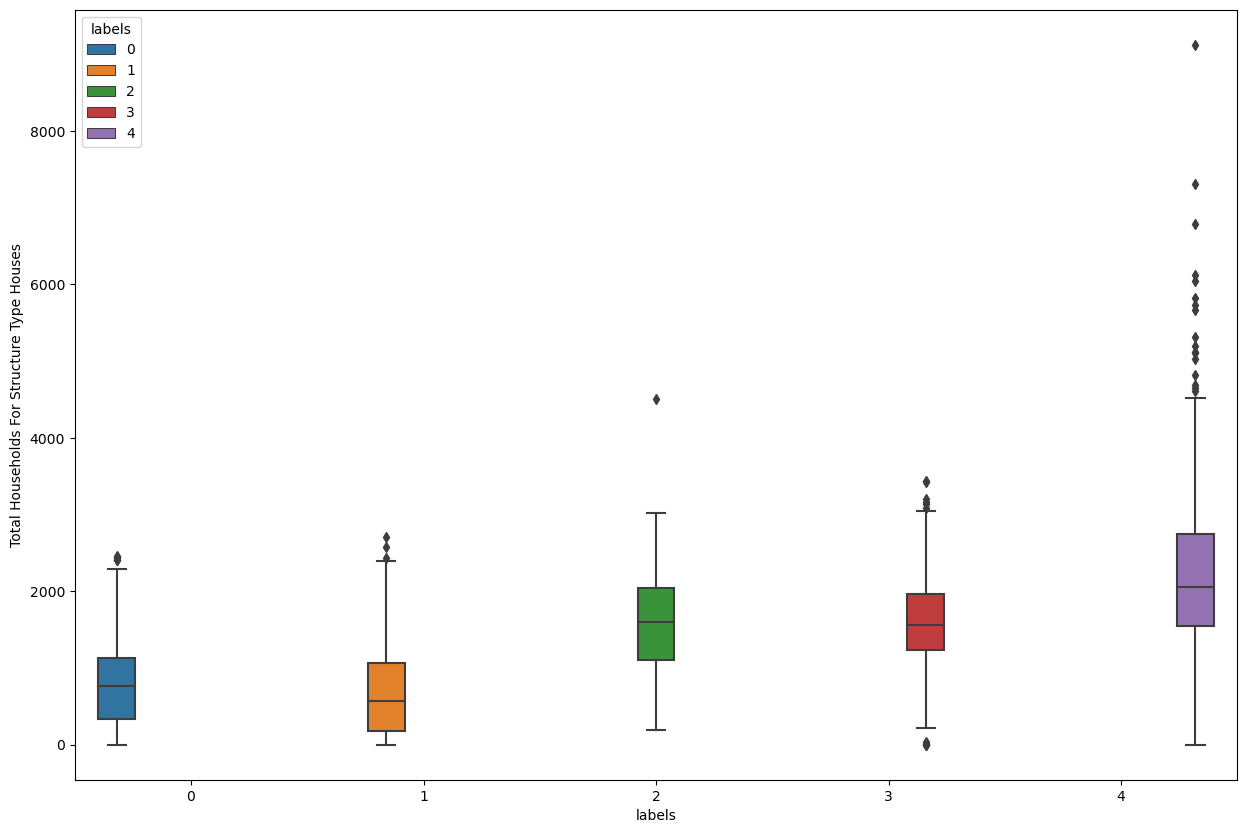

In [30]:
plt.figure(figsize=(15,10))
sns.boxplot(x="labels", y="Total Households For Structure Type Houses",
            hue="labels",
            data=labeled_data)

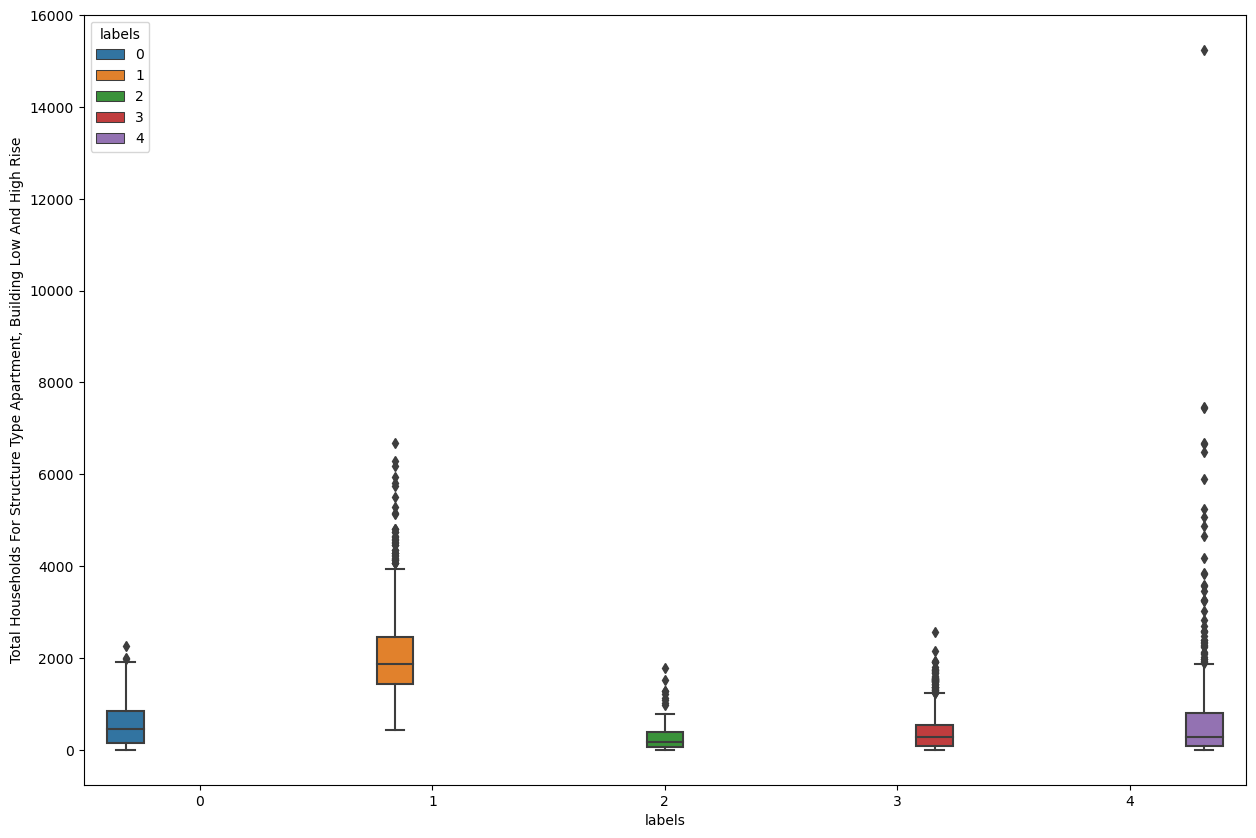

In [31]:
plt.figure(figsize=(15,10))
sns.boxplot(x="labels", y="Total Households For Structure Type Apartment, Building Low And High Rise",
            hue="labels",
            data=labeled_data)

# BIRCH Clustering

In [32]:
# model
brc = Birch(n_clusters = 5)
brc.fit(scaled_df)

Birch(n_clusters=5)

In [33]:
# add labels back to original data
labels = pd.DataFrame(brc.labels_)
df['brc_labels'] = labels
labeled_data['brc_labels'] = labels
labeled_data

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter,labels,brc_labels
0,4051,1441,68242.12,1441,323,199,53,182,526,911,525,5,1343,919,424,0,0
1,2329,1026,88172.37,1026,927,70,15,3,0,792,230,4,991,778,213,0,2
2,5276,2071,103853.38,2071,3,607,567,651,106,1418,652,1,1903,1522,381,3,1
3,5967,2203,82796.63,2203,133,1695,248,79,0,1397,806,0,2079,1272,807,1,1
4,4236,1419,91648.22,1419,0,7,127,938,143,914,505,0,1348,1186,162,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4975,2588,953,108823.38,953,0,3,31,501,276,926,27,0,875,847,28,3,1
4976,9036,3859,68735.64,3859,678,986,386,359,448,2388,1436,35,3649,2602,1047,1,1
4977,4689,1895,71370.58,1895,164,485,511,523,29,677,1038,180,1764,1219,545,3,1
4978,3673,1038,58258.26,1038,544,185,40,95,13,796,242,0,893,546,347,0,1


In [34]:
labeled_data.groupby('brc_labels').mean()

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter,labels
brc_labels,,,,,,,,,,,,,,,,
0,7485.835145,2478.092391,114831.495091,2478.092391,78.324275,101.079710,130.923913,507.072464,519.771739,2034.688406,439.530797,3.873188,2279.329710,1915.789855,363.246377,3.538043
1,4256.498260,1612.153793,81703.681886,1612.153793,251.660056,556.416145,287.885177,202.614823,88.605776,1164.764440,435.631872,11.757481,1520.619694,1123.428323,396.256089,1.385873
2,5091.650847,2343.185763,55256.221871,2343.185763,781.395254,724.776271,254.214237,203.937627,93.126780,731.264407,1604.348475,7.572881,2207.088136,1006.744407,1200.342373,0.735593
3,5879.653846,2326.115385,82680.299872,2326.115385,172.884615,682.141026,356.333333,341.205128,180.115385,1598.243590,319.141026,408.730769,2190.551282,1793.051282,396.397436,2.064103
4,394.000000,8.000000,50000.000000,8.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,5.000000,2.000000,3.000000,4.000000


In [35]:
labeled_data['brc_labels'].value_counts()

1    2874
2    1475
0     552
3      78
4       1
Name: brc_labels, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


(0.0, 300000.0)

<Figure size 1000x1000 with 0 Axes>

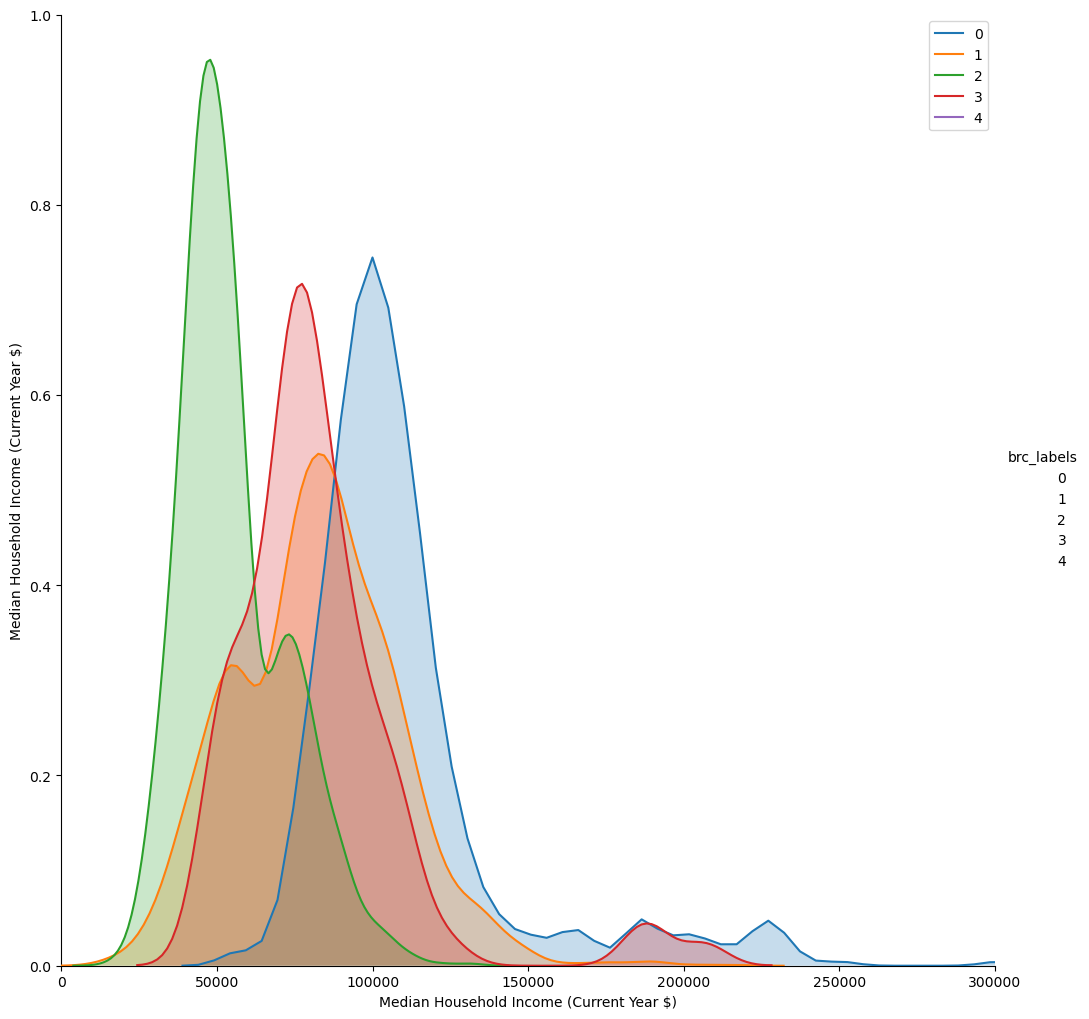

In [51]:
plt.figure(figsize=(10,10))
sns.pairplot(labeled_data[["Median Household Income (Current Year $)", "brc_labels"]], hue="brc_labels", size=10)
plt.legend()
plt.xlim(0,300000)

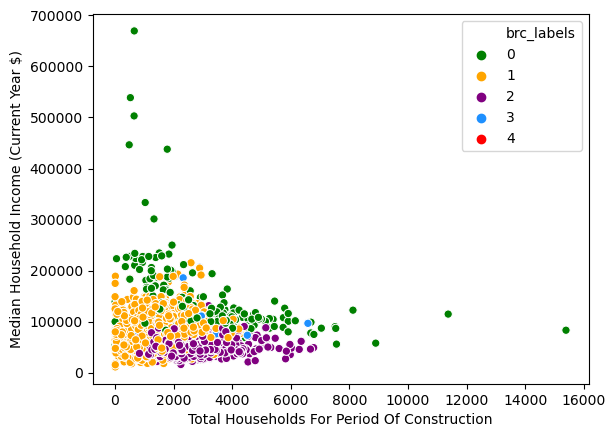

In [69]:
sns.scatterplot(x=labeled_data["Total Households For Period Of Construction"], 
                y=labeled_data["Median Household Income (Current Year $)"],
                hue=labeled_data["brc_labels"],
                palette=['green','orange','purple','dodgerblue','red'])

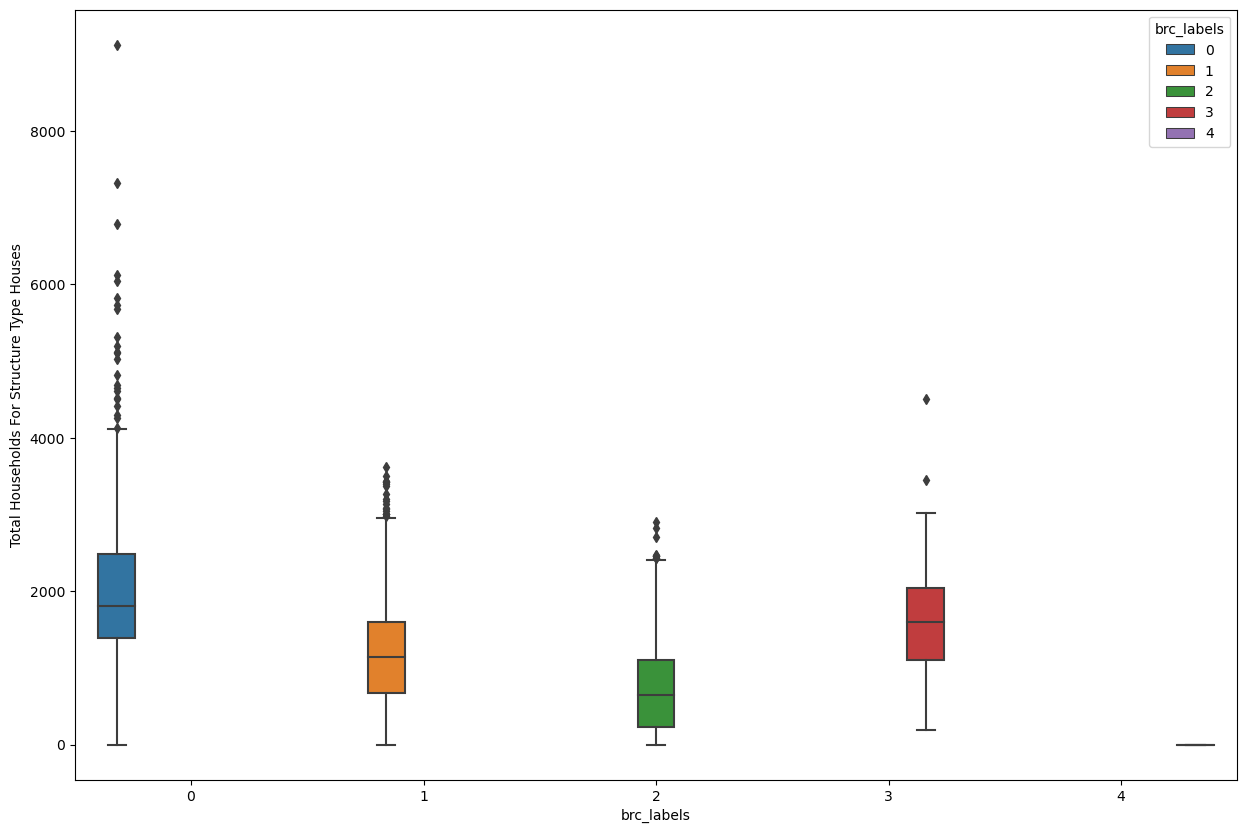

In [42]:
plt.figure(figsize=(15,10))
sns.boxplot(x="brc_labels", y="Total Households For Structure Type Houses",
            hue="brc_labels",
            data=labeled_data)

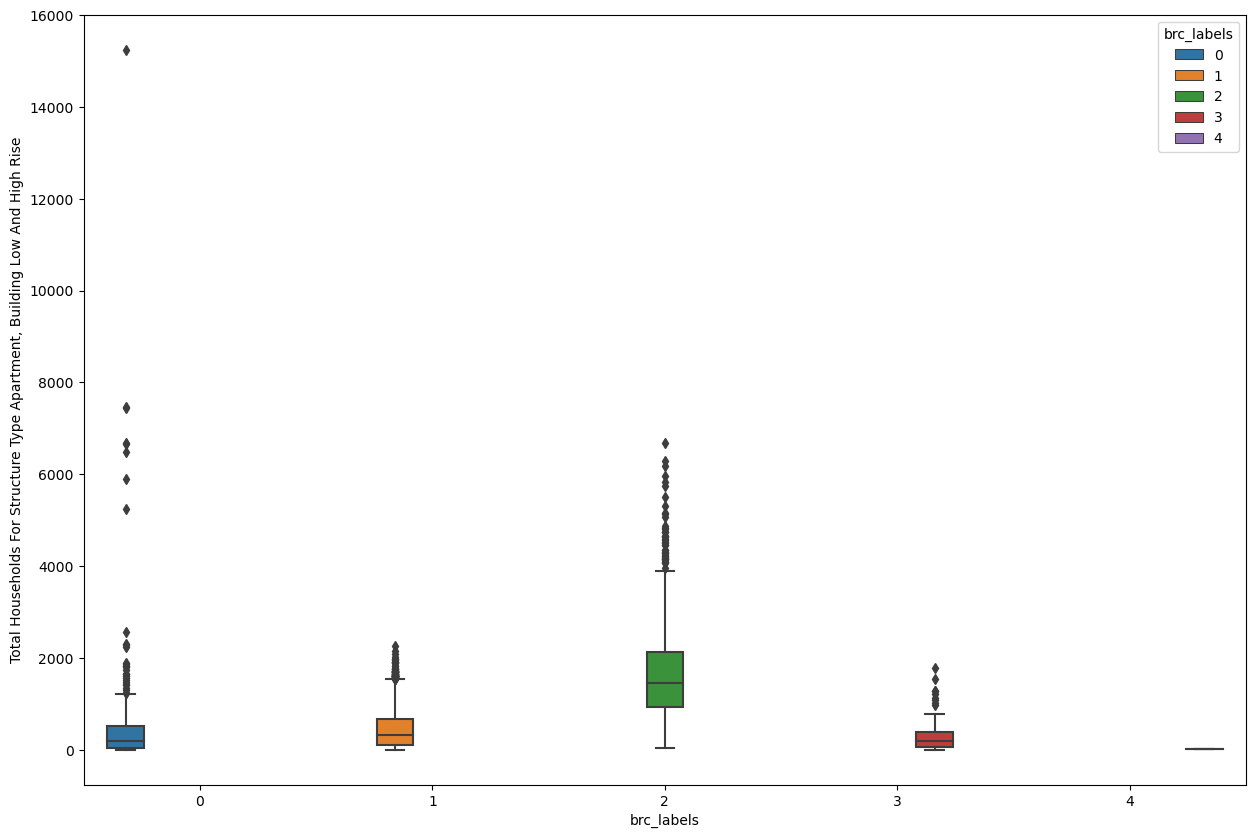

In [43]:
plt.figure(figsize=(15,10))
sns.boxplot(x="brc_labels", y="Total Households For Structure Type Apartment, Building Low And High Rise",
            hue="brc_labels",
            data=labeled_data)

# Part Two

In [44]:
# final model
model2 = KMeans(n_clusters = 5, **kmeans_kwargs)
X = df.drop(columns=['income','labels','brc_labels'])
scaler = StandardScaler()
scaled_df2 = scaler.fit_transform(X)
model2.fit(scaled_df2)

KMeans(n_clusters=5, random_state=1111)

In [45]:
# add labels back to original data
labels = pd.DataFrame(model2.labels_)
df['labels_2'] = labels
labeled_data['labels_2'] = labels

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1200x800 with 0 Axes>

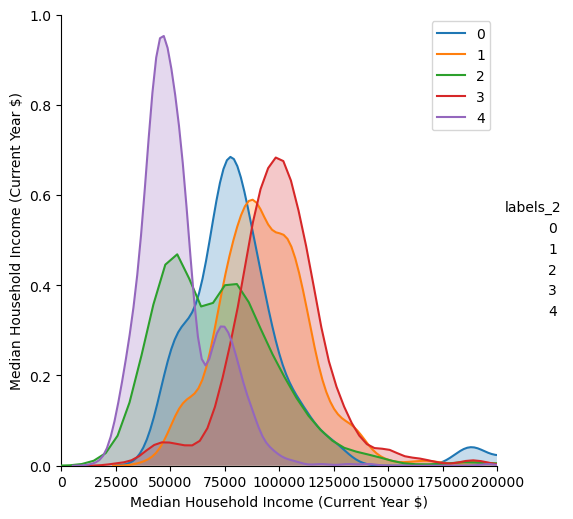

In [46]:
plt.figure(figsize=(12,8))
sns.pairplot(labeled_data[["Median Household Income (Current Year $)", "labels_2"]], hue="labels_2", size=5)
plt.xlim(0,200000)
plt.legend()

In [47]:
labeled_data.groupby('labels_2').mean()

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter,labels,brc_labels
labels_2,,,,,,,,,,,,,,,,,
0,5860.950000,2318.412500,82865.744000,2318.412500,173.762500,667.862500,359.250000,364.237500,188.650000,1596.800000,316.612500,405.000000,2187.300000,1797.412500,388.812500,2.000000,2.875000
1,5832.127483,2106.517384,93496.181026,2106.517384,141.566225,525.937914,529.585265,448.505795,153.903146,1659.757450,434.500828,12.259106,1983.730960,1600.262417,383.462748,2.930464,0.978477
2,3246.736207,1316.897845,73802.120409,1316.897845,470.934483,456.445259,117.064655,87.718103,41.961638,808.339224,499.813793,8.744828,1245.871121,797.154310,447.493534,0.316810,1.236638
3,8537.023656,2943.507527,100609.399785,2943.507527,63.718280,142.131183,138.092473,441.873118,657.913978,2200.486022,734.150538,8.870968,2703.021505,2192.055914,510.954839,3.969892,0.318280
4,5863.637266,2739.582139,53614.576880,2739.582139,689.573319,1062.164278,328.699008,231.234840,97.783903,708.550165,2022.919515,8.112459,2575.652701,1064.435502,1511.214994,0.997795,1.800441


In [48]:
labeled_data.groupby('labels').mean()

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter,brc_labels,labels_2
labels,,,,,,,,,,,,,,,,,
0,3180.061137,1317.436019,69222.866512,1317.436019,524.484360,436.758768,106.481043,80.595735,37.010427,769.559716,539.192417,8.683886,1246.748341,768.863981,476.614218,1.290047,2.042654
1,5833.310231,2729.161716,51427.130495,2729.161716,624.809681,1057.130913,349.074807,249.870187,104.680968,672.861386,2048.246425,8.053905,2564.998900,1042.464246,1522.532453,1.806381,3.800880
2,5860.950000,2318.412500,82865.744000,2318.412500,173.762500,667.862500,359.250000,364.237500,188.650000,1596.800000,316.612500,405.000000,2187.300000,1797.412500,388.812500,2.875000,0.000000
3,5551.864250,1991.425018,98657.546034,1991.425018,151.530206,550.063255,472.690121,390.146411,139.840085,1606.181237,373.743426,11.500355,1876.053305,1532.696517,343.239517,0.939588,1.216063
4,8526.987342,2934.335443,101175.993523,2934.335443,65.052743,142.042194,140.533755,452.272152,649.544304,2217.122363,707.181435,10.031646,2696.118143,2195.900844,500.206751,0.308017,2.943038


In [49]:
# separate clusters
cluster_1 = df.loc[df['labels_2'] == 0]
cluster_1 = cluster_1.reset_index(drop=True)
cluster_1_X = cluster_1.drop(columns=['labels','income','brc_labels','labels_2'])
cluster_1_Y = cluster_1[['income']]
X_train1, X_test1, y_train1, y_test1 = train_test_split(cluster_1_X, cluster_1_Y, test_size=0.4, random_state=42)


cluster_2 = df.loc[df['labels_2'] == 1]
cluster_2 = cluster_2.reset_index(drop=True)
cluster_2_X = cluster_2.drop(columns=['labels','income','brc_labels','labels_2'])
cluster_2_Y = cluster_2[['income']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(cluster_2_X, cluster_2_Y, test_size=0.4, random_state=42)


cluster_3 = df.loc[df['labels_2'] == 2]
cluster_3 = cluster_3.reset_index(drop=True)
cluster_3_X = cluster_3.drop(columns=['labels','income','brc_labels','labels_2'])
cluster_3_Y = cluster_3[['income']]
X_train3, X_test3, y_train3, y_test3 = train_test_split(cluster_3_X, cluster_3_Y, test_size=0.4, random_state=42)

cluster_4 = df.loc[df['labels_2'] == 3]
cluster_4 = cluster_4.reset_index(drop=True)
cluster_4_X = cluster_4.drop(columns=['labels','income','brc_labels','labels_2'])
cluster_4_Y = cluster_4[['income']]
X_train4, X_test4, y_train4, y_test4 = train_test_split(cluster_4_X, cluster_4_Y, test_size=0.4, random_state=42)

cluster_5 = df.loc[df['labels_2'] == 4]
cluster_5 = cluster_5.reset_index(drop=True)
cluster_5_X = cluster_5.drop(columns=['labels','income','brc_labels','labels_2'])
cluster_5_Y = cluster_5[['income']]
X_train5, X_test5, y_train5, y_test5 = train_test_split(cluster_5_X, cluster_5_Y, test_size=0.4, random_state=42)

In [523]:
# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()), 
                    ('clf', LinearRegression())])

pipe_knn = Pipeline([('scl', StandardScaler()),
                     ('clf', KNeighborsRegressor(n_neighbors=5))])

pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('clf', DecisionTreeRegressor(random_state=0))])

pipe_svr = Pipeline([('scl', StandardScaler()), 
                     ('clf', SVR())])

pipe_gbr = Pipeline([('scl', StandardScaler()), 
                     ('clf', GradientBoostingRegressor(random_state=0))])

In [565]:
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
param_gbr_range= [100,200,300]

grid_params_lr = {'clf__fit_intercept':[True,False], 'clf__copy_X':[True, False]}

grid_params_dt = [{'clf__criterion': ['mse']}]

grid_params_knn = [{'clf__n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}]

grid_params_svr = [{'clf__kernel': ['linear', 'rbf','poly'], 'clf__C': param_range}]

grid_params_gbr =[{'clf__n_estimators': param_gbr_range,
                   'clf__learning_rate': param_range_fl,
                   'clf__loss': ['ls','lad']}]

In [566]:
gs_lr = GridSearchCV(estimator=pipe_lr,
                     param_grid=grid_params_lr,
                     scoring='neg_root_mean_squared_error',
                     cv=10)

gs_svr = GridSearchCV(estimator=pipe_svr,
                      param_grid=grid_params_svr,
                      scoring='neg_root_mean_squared_error',
                      cv=10)

gs_knn = GridSearchCV(estimator=pipe_knn,
                      param_grid=grid_params_knn,
                      scoring='neg_root_mean_squared_error',
                      cv=10)

gs_dt = GridSearchCV(estimator=pipe_dt,
                     param_grid=grid_params_dt,
                     scoring='neg_root_mean_squared_error',
                     cv=10)

gs_gbr = GridSearchCV(estimator=pipe_gbr,
                      param_grid=grid_params_gbr,
                      scoring='neg_root_mean_squared_error',
                      cv=10)

In [567]:
grids = [gs_lr, gs_dt, gs_knn, gs_svr, gs_gbr]
grid_dict = {0: 'Linear Regression', 1: 'Decision Tree', 2: 'KNN', 3: 'SVR', 4:'Gradient Boosting Regression'}

In [568]:
xtrain_dict = [X_train1, X_train2, X_train3, X_train4, X_train5]
ytrain_dict = [y_train1, y_train2, y_train3, y_train4, y_train5]

xtest_dict = [X_test1, X_test2, X_test3, X_test4, X_test5]
ytest_dict = [y_test1, y_test2, y_test3, y_test4, y_test5]

In [569]:
print('Performing model optimizations...')
best_rmse = 10000000000000000000000000000000000
best_clf = 0
best_gs = ''
for i in range(0,5):
    n=  int(i+1)
    print("Cluster: %i" % (n))
    for idx, gs in enumerate(grids):
        print('\nEstimator: %s' % grid_dict[idx])
        # Fit grid search
        gs.fit(xtrain_dict[i], ytrain_dict[i].values.ravel())
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Predict on test data with best params
        y_pred = gs.predict(xtest_dict[i])
        rmse = math.sqrt(mean_squared_error(ytest_dict[i], y_pred))
        print('Test set RMSE score for best params: %.3f ' % (rmse))
        # Track best (highest test accuracy) model
        if rmse < best_rmse:
            best_rmse = rmse
            best_gs = gs
            best_clf = idx
    print('\nRegressor with best test set accuracy: %s' % grid_dict[best_clf])
    print('\n')
    best_rmse=10000000000000000000000000000000000

Performing model optimizations...
Cluster: 1

Estimator: Linear Regression
Best params: {'clf__copy_X': True, 'clf__fit_intercept': True}
Test set RMSE score for best params: 17404.741 

Estimator: Decision Tree
Best params: {'clf__criterion': 'mse'}
Test set RMSE score for best params: 19171.941 

Estimator: KNN
Best params: {'clf__n_neighbors': 17}
Test set RMSE score for best params: 17514.557 

Estimator: SVR
Best params: {'clf__C': 10, 'clf__kernel': 'linear'}
Test set RMSE score for best params: 19054.725 

Estimator: Gradient Boosting Regression
Best params: {'clf__learning_rate': 0.1, 'clf__loss': 'lad', 'clf__n_estimators': 300}
Test set RMSE score for best params: 16628.483 

Regressor with best test set accuracy: Gradient Boosting Regression


Cluster: 2

Estimator: Linear Regression
Best params: {'clf__copy_X': True, 'clf__fit_intercept': True}
Test set RMSE score for best params: 19737.766 

Estimator: Decision Tree
Best params: {'clf__criterion': 'mse'}
Test set RMSE scor

# Test Set Data

In [1076]:
df_test = pd.read_csv('CensusCanada2016Test.csv')

In [1077]:
# drop equal value columns
df_test = df_test.drop(columns=['Total Households For Period Of Construction'])

# rename columns
df_test.columns=['population', 'households',  
             'hh_before_1961','hh_1961_1980','hh_1981_1990','hh_1991_2000','hh_2001_2005',
             'hh_type_house', 'hh_type_app', 'hh_type_other', 
             'hh_tenure', 'hh_tenure_owner', 'hh_tenure_renter']

# derive additional columns
df_test['hh_tenure_other'] = df_test['hh_tenure'] - df_test['hh_tenure_owner'] - df_test['hh_tenure_renter']
df_test['hh_after_2005'] = df_test['households'] - df_test['hh_before_1961'] - df_test['hh_1961_1980'] \
                      - df_test['hh_1981_1990'] - df_test['hh_1991_2000'] - df_test['hh_2001_2005']

df_test["persons_per_hh"]=df_test['population']/df_test['households']
                          
for i in range(0,721):
    if df_test['households'][i]>0:

        df_test["persons_per_hh"][i] = df_test['population'][i]/df_test['households'][i]
    else:
        df_test["persons_per_hh"][i]=0

# drop columns
df_test = df_test.drop(columns=['population'])
df_test = df_test.drop(columns=['hh_tenure'])
df_test = df_test.drop(columns=['households'])

C:\Users\buttb\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\buttb\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1078]:
df_test = df_test.drop(columns=['hh_tenure_owner'])
df_test = df_test.drop(columns=['hh_tenure_renter'])
df_test = df_test.drop(columns=['hh_tenure_other'])
df_test

,hh_before_1961,hh_1961_1980,hh_1981_1990,hh_1991_2000,hh_2001_2005,hh_type_house,hh_type_app,hh_type_other,hh_after_2005,persons_per_hh
0,15,21,46,648,114,883,10,0,49,3.014558
1,17,839,218,27,33,1025,486,0,377,2.570483
2,767,615,223,435,166,1390,1378,0,562,2.533960
3,1540,969,437,244,457,2102,2461,14,930,1.996067
4,44,94,34,115,184,1069,98,0,696,3.096829
...,...,...,...,...,...,...,...,...,...,...
716,0,32,14,12,0,55,0,9,6,3.109375
717,799,575,186,114,25,152,1561,5,19,1.806752
718,360,101,3,11,0,481,20,0,26,2.638723
719,227,553,408,91,19,1143,236,0,81,3.109500


In [1079]:
# check for null values
df_test.isnull().sum()

hh_before_1961    0
hh_1961_1980      0
hh_1981_1990      0
hh_1991_2000      0
hh_2001_2005      0
hh_type_house     0
hh_type_app       0
hh_type_other     0
hh_after_2005     0
persons_per_hh    0
dtype: int64

In [1080]:
# final model
test_pred = model2.predict(df_test) #labels test data

In [1081]:
# append the cluster label to dataframe
labels = pd.DataFrame(model2.labels_)
df_test['cluster'] = labels
df_test

,hh_before_1961,hh_1961_1980,hh_1981_1990,hh_1991_2000,hh_2001_2005,hh_type_house,hh_type_app,hh_type_other,hh_after_2005,persons_per_hh,cluster
0,15,21,46,648,114,883,10,0,49,3.014558,4
1,17,839,218,27,33,1025,486,0,377,2.570483,4
2,767,615,223,435,166,1390,1378,0,562,2.533960,2
3,1540,969,437,244,457,2102,2461,14,930,1.996067,0
4,44,94,34,115,184,1069,98,0,696,3.096829,2
...,...,...,...,...,...,...,...,...,...,...,...
716,0,32,14,12,0,55,0,9,6,3.109375,0
717,799,575,186,114,25,152,1561,5,19,1.806752,2
718,360,101,3,11,0,481,20,0,26,2.638723,4
719,227,553,408,91,19,1143,236,0,81,3.109500,4


In [1082]:
# create sliced dataframes for each cluster
cluster1_test = df_test[df_test["cluster"]==0].drop(columns=["cluster"])
cluster2_test = df_test[df_test["cluster"]==1].drop(columns=["cluster"])
cluster3_test = df_test[df_test["cluster"]==2].drop(columns=["cluster"])
cluster4_test = df_test[df_test["cluster"]==3].drop(columns=["cluster"])
cluster5_test = df_test[df_test["cluster"]==4].drop(columns=["cluster"])

In [995]:
# Cluster 1
cluster1bestparam = [{'clf__learning_rate': [0.1], 'clf__loss': ['lad'], 'clf__n_estimators': [300]}]

# Cluster 2
cluster2bestparam = [{'clf__learning_rate': [0.1], 'clf__loss':[ 'lad'], 'clf__n_estimators':[200]}]

# Cluster 3
cluster3bestparam = [{'clf__learning_rate': [0.1], 'clf__loss':[ 'lad'], 'clf__n_estimators':[200]}]

# Cluster 4
cluster4bestparam = [{'clf__n_neighbors': [4]}]

# Cluster 5
cluster5bestparam = [{'clf__n_neighbors': [20]}]

In [732]:
# Run Each Model Using Grid Search with Optimial Parameters
cluster1_model = GridSearchCV(estimator=pipe_gbr,
                              param_grid=cluster1bestparam,
                              scoring='neg_root_mean_squared_error',
                              cv=10)

cluster2_model = GridSearchCV(estimator=pipe_gbr,
                              param_grid=cluster2bestparam,
                              scoring='neg_root_mean_squared_error',
                              cv=10)

cluster3_model = GridSearchCV(estimator=pipe_gbr,
                              param_grid=cluster3bestparam,
                              scoring='neg_root_mean_squared_error',
                              cv=10)

cluster4_model = GridSearchCV(estimator=pipe_knn,
                              param_grid=cluster4bestparam,
                              scoring='neg_root_mean_squared_error',
                              cv=10)

cluster5_model = GridSearchCV(estimator=pipe_knn,
                              param_grid=cluster5bestparam,
                              scoring='neg_root_mean_squared_error',
                              cv=10)

In [733]:
cluster1_model.fit(xtrain_dict[0], ytrain_dict[0].values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('clf',
                                        GradientBoostingRegressor(random_state=0))]),
             param_grid=[{'clf__learning_rate': [0.1], 'clf__loss': ['lad'],
                          'clf__n_estimators': [300]}],
             scoring='neg_root_mean_squared_error')

In [734]:
cluster2_model.fit(xtrain_dict[1], ytrain_dict[1].values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('clf',
                                        GradientBoostingRegressor(random_state=0))]),
             param_grid=[{'clf__learning_rate': [0.1], 'clf__loss': ['lad'],
                          'clf__n_estimators': [200]}],
             scoring='neg_root_mean_squared_error')

In [735]:
cluster3_model.fit(xtrain_dict[2], ytrain_dict[2].values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('clf',
                                        GradientBoostingRegressor(random_state=0))]),
             param_grid=[{'clf__learning_rate': [0.1], 'clf__loss': ['lad'],
                          'clf__n_estimators': [200]}],
             scoring='neg_root_mean_squared_error')

In [736]:
cluster4_model.fit(xtrain_dict[3], ytrain_dict[3].values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('clf', KNeighborsRegressor())]),
             param_grid=[{'clf__n_neighbors': [4]}],
             scoring='neg_root_mean_squared_error')

In [737]:
cluster5_model.fit(xtrain_dict[4], ytrain_dict[4].values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('clf', KNeighborsRegressor())]),
             param_grid=[{'clf__n_neighbors': [20]}],
             scoring='neg_root_mean_squared_error')

In [996]:
# Predict Income from Test Data
test_pred1 = cluster1_model.predict(cluster1_test)
test_pred2 = cluster1_model.predict(cluster2_test)
test_pred3 = cluster1_model.predict(cluster3_test)
test_pred4 = cluster1_model.predict(cluster4_test)
test_pred5 = cluster1_model.predict(cluster5_test)

In [1083]:
# Create series based of predictions
cluster1_test["predictions"] = test_pred1
cluster2_test["predictions"] = test_pred2
cluster3_test["predictions"] = test_pred3
cluster4_test["predictions"] = test_pred4
cluster5_test["predictions"] = test_pred5

In [1084]:
# create temporary predictions variables
df_test["predictions1"] = cluster1_test["predictions"]
df_test["predictions2"] = cluster2_test["predictions"]
df_test["predictions3"] = cluster3_test["predictions"]
df_test["predictions4"] = cluster4_test["predictions"]
df_test["predictions5"] = cluster5_test["predictions"]

In [1085]:
# fill null values with 0
df_test.fillna(0, inplace=True)

In [1070]:
# Create final prediction column
df_test['income_pred'] = []

In [1087]:
# Add all the columns up
# should only ad itself to 0 as null values were based on index numbers
df_test['income_pred'] = df_test["predictions1"] + df_test["predictions2"] + df_test["predictions3"] + df_test["predictions4"] + df_test["predictions5"] 

In [1113]:
df_test.columns

Index(['hh_before_1961', 'hh_1961_1980', 'hh_1981_1990', 'hh_1991_2000',
       'hh_2001_2005', 'hh_type_house', 'hh_type_app', 'hh_type_other',
       'hh_after_2005', 'persons_per_hh', 'cluster', 'predictions1',
       'predictions2', 'predictions3', 'predictions4', 'predictions5',
       'income_pred'],
      dtype='object')

Save Predictions As Array in Text File

In [1091]:
final_pred = df_test["income_pred"]

In [1093]:
with open('Team7Predictions.txt', 'wb') as f:
    np.save(f, final_pred, allow_pickle=False)

In [1094]:
with open('Team7Predictions.txt', 'rb') as f:
    test_set_predictions = np.load(f)

In [1095]:
test_set_predictions

array([63847.23919571, 75715.91618319, 68044.03709325, 56622.44970382,
       72683.70995762, 49296.97776449, 79019.3465423 , 63457.42148888,
       81966.31353318, 85661.97093091, 61268.2480181 , 88758.30194351,
       69199.98081459, 82661.68496392, 69805.62239174, 74082.58238851,
       66460.2519266 , 82585.35173191, 84317.74166464, 56377.52310396,
       58711.51411911, 74225.74377752, 74554.58493001, 60925.27050366,
       72304.43658128, 57224.31959963, 68222.70118005, 57224.31959963,
       78888.13974899, 60884.3620511 , 76425.75244567, 45099.82024986,
       53424.70017379, 62829.64121959, 68040.97856012, 75136.55091743,
       76476.35937779, 71331.44616949, 85416.78183384, 62724.41504603,
       80499.51999803, 54859.21291356, 80120.18730668, 54254.92194037,
       58059.53896542, 71282.4908152 , 48287.55541326, 54928.54983194,
       40790.20813674, 49728.84007551, 69598.71561688, 79011.39233303,
       62258.52994211, 67160.60984415, 44392.95287391, 46975.91668106,
      